In [1]:
#| export
verbose                       = None 
show_plots                    = None
reset_kernel                  = None 
pre_configured_case           = None
case_id                       = None
frequency_factor              = None
frequency_factor_change_alias = None
cuda_device                   = None
check_parameters              = True

## Checking input parameters

In [2]:
#| export
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias:", frequency_factor_change_alias,
        "cuda_device:", cuda_device
)

--- Check parameters ---
verbose: None show_plots: None reset_kernel: None pre_configured_case: None case_id: None frequency_factor: None frequency_factor_change_alias: None cuda_device: None


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [3]:
#| export
verbose                       = 1  if verbose is None else verbose
show_plots                    = True if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = False if pre_configured_case is None else pre_configured_case
case_id                       = 1 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 0 if  cuda_device is None else cuda_device

# Create artifact from time series dataframe
Gets a .tsf or .csv with a time serie, convert int to np.dataframe and loads it to weights and biases (W&B)

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection
### VsCode update patch
Initial notebook setup when using VSCode

In [4]:
#| export
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables
- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so (eg. `get_enc_embeddings`)
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [5]:
#| export
import dvats.config as cfg_

In [6]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [7]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code


In [8]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Path and Artiffact configurattions
This notebook gets configuration from `config\base.yaml` and `config\01-dataset_artifact.yaml`

In [9]:
#| export
base_path = Path.home()

In [10]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

artifact_name: Tourism-monthly
csv_config: {'header': 0}
data_cols: [0]
data_fpath: ~/data/tourism_monthly_dataset.tsf
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1mo
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

#### Check file content (if wanted)

In [11]:
#| hide
if verbose  > 0:
    fpath=os.path.expanduser(config.data_fpath)
    print(fpath)
    try: 
        with open(fpath, 'r') as file:
            for _ in range(13):
                line = file.readline()
                print(line, end='')
        data, _, _, _, _ = convert_tsf_to_dataframe(fpath)
        print("Timestamp", data.start_timestamp)
    except Exception as e:
        print("Error while converting file. Maybe not a tsf: ", e)

/home/macu/data/tourism_monthly_dataset.tsf
Error while converting file. Maybe not a tsf:  'utf-8' codec can't decode byte 0x96 in position 314: invalid start byte


#### Extract data

In [12]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')


In [13]:
#| hide
if verbose > 0:
    print(f'File loaded successfully')
    print(df.shape)
    display(df.head())

File loaded successfully
(333, 366)


,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,1149.8700,65072.37,37047.0,7611.0,27693.0,12570.0,4289.0,55563.0,4262.0,6699.0,...,5807.0,820.0,4205.0,447.0,1401.0,901.0,798.0,3688.0,11464.0,3841.0
1,1053.8002,48612.20,32836.0,6859.0,15075.0,12691.0,4312.0,45408.0,3329.0,5380.0,...,6170.0,675.0,3647.0,437.0,1378.0,648.0,625.0,6638.0,9007.0,2768.0
2,1388.8798,58452.59,51094.0,9247.0,22602.0,18729.0,8679.0,72897.0,4016.0,8750.0,...,17877.0,978.0,5963.0,832.0,2875.0,2691.0,1141.0,7579.0,15749.0,6853.0
3,1783.3702,57033.97,52629.0,10924.0,23530.0,16028.0,7649.0,45770.0,3702.0,14168.0,...,67815.0,4522.0,19322.0,8188.0,15114.0,26692.0,10660.0,6820.0,29511.0,10796.0
4,1921.0252,71498.95,56884.0,9064.0,26817.0,13644.0,6460.0,46733.0,3864.0,13881.0,...,72377.0,3657.0,16092.0,10600.0,23397.0,37096.0,14759.0,8189.0,39965.0,14991.0


#### Set the time column (if any) as index

In [14]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,1149.8700,65072.37,37047.0,7611.0,27693.0,12570.0,4289.0,55563.0,4262.0,6699.0,...,5807.0,820.0,4205.0,447.0,1401.0,901.0,798.0,3688.0,11464.0,3841.0
1,1053.8002,48612.20,32836.0,6859.0,15075.0,12691.0,4312.0,45408.0,3329.0,5380.0,...,6170.0,675.0,3647.0,437.0,1378.0,648.0,625.0,6638.0,9007.0,2768.0
2,1388.8798,58452.59,51094.0,9247.0,22602.0,18729.0,8679.0,72897.0,4016.0,8750.0,...,17877.0,978.0,5963.0,832.0,2875.0,2691.0,1141.0,7579.0,15749.0,6853.0
3,1783.3702,57033.97,52629.0,10924.0,23530.0,16028.0,7649.0,45770.0,3702.0,14168.0,...,67815.0,4522.0,19322.0,8188.0,15114.0,26692.0,10660.0,6820.0,29511.0,10796.0
4,1921.0252,71498.95,56884.0,9064.0,26817.0,13644.0,6460.0,46733.0,3864.0,13881.0,...,72377.0,3657.0,16092.0,10600.0,23397.0,37096.0,14759.0,8189.0,39965.0,14991.0


#### Set dataframe frequency

In [23]:
def infer_or_inject_freq_(df, injected_freq='1s', start_date=None, **kwargs):
    """
        Infer index frequency. If there's not a proper time index, create fake timestamps,
        keeping the desired `injected_freq`. If that is None, set a default one of 1 second.
        start_date: the first date of the index (int or string).
    """
    inferred_freq = pd.infer_freq(df.index)
    if inferred_freq == 'N':
        if injected_freq.endswith('mo'):
            months = int(injected_freq[:-2])
            freq = f'{months}M'
            print(f"df~{df.shape} | freq {freq}")
            start_date = pd.to_datetime(ifnone(start_date, df.index[0]))
            new_index = pd.date_range(start=start_date, periods=len(df), freq=freq)
            df.index = new_index
            print(df.shape)
            df.index.freq = pd.infer_freq(df.index)
        else:
            timedelta = pd.to_timedelta(injected_freq)
            df.index = pd.to_datetime(ifnone(start_date, 0), **kwargs) + timedelta*df.index
            df.index.freq = pd.infer_freq(df.index)
    else:
        df.index.freq = inferred_freq
    return df

In [24]:
#| export
df = infer_or_inject_freq_(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

df~(333, 366) | freq 1M
(333, 366)
<MonthEnd>


In [25]:
df.head

<bound method NDFrame.head of                   0         1        2        3        4        5       6    \
1979-01-31  1149.8700  65072.37  37047.0   7611.0  27693.0  12570.0  4289.0   
1979-02-28  1053.8002  48612.20  32836.0   6859.0  15075.0  12691.0  4312.0   
1979-03-31  1388.8798  58452.59  51094.0   9247.0  22602.0  18729.0  8679.0   
1979-04-30  1783.3702  57033.97  52629.0  10924.0  23530.0  16028.0  7649.0   
1979-05-31  1921.0252  71498.95  56884.0   9064.0  26817.0  13644.0  6460.0   
...               ...       ...      ...      ...      ...      ...     ...   
2006-05-31        NaN       NaN      NaN      NaN      NaN      NaN     NaN   
2006-06-30        NaN       NaN      NaN      NaN      NaN      NaN     NaN   
2006-07-31        NaN       NaN      NaN      NaN      NaN      NaN     NaN   
2006-08-31        NaN       NaN      NaN      NaN      NaN      NaN     NaN   
2006-09-30        NaN       NaN      NaN      NaN      NaN      NaN     NaN   

                7    

#### Select only the needed variables

In [26]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

data_cols:  [0]
Num. variables: 1


#### Ensure data integrity

In [18]:
#| export
#Duplicated rows
if verbose > 0: print("df shape before dropping duplicates", df.shape)
df.drop_duplicates()
if verbose > 0: print("df shape after dropping duplicates", df.shape)
# Verificar si hay duplicados en el índice del dataframe
if df.index.duplicated().any():
    raise ValueError("Duplicated index names")

df shape before dropping duplicates (7397222, 1)
df shape after dropping duplicates (7397222, 1)


In [19]:
#| export
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

#### Show time series plot

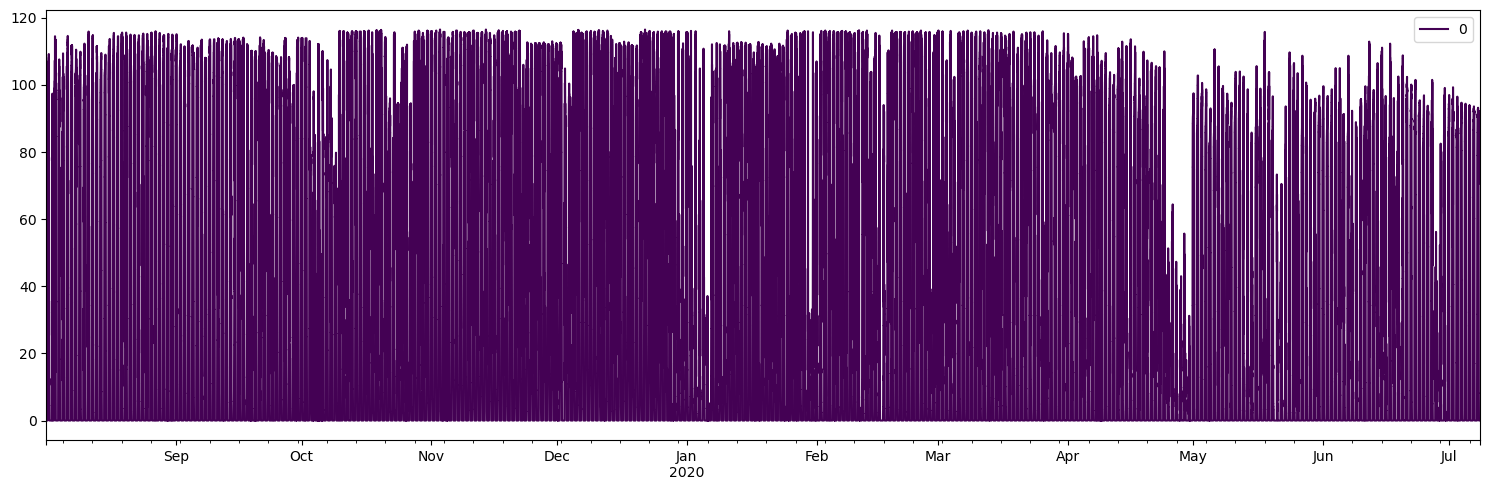

None

In [20]:
#| hide
if show_plots:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

### Data Transformation

__Handle Missing Values, Resample and Normalize__

> In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied.
> 
> This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

#### Training data

##### Build dataframe

In [21]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

##### Build training artifact

In [22]:
#| export
training_artifact = TSArtifact.from_df(
    df_training, 
    name=config.artifact_name, 
    missing_values_technique=config.missing_values_technique,
    resampling_freq=config.resampling_freq, 
    normalize=config.normalize_training, 
    path=str(Path.home()/config.wandb_artifacts_path)
)
if verbose > 0: display(training_artifact.metadata)

About to write df to  /home/macu/data/wandb_artifacts/-2535364569820284064


{'TS': {'sd': '2019-08-01 00:00:03',
  'ed': '2020-07-08 11:08:07',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 7397222,
  'freq': '<4 * Seconds>',
  'vars': [0],
  'hash': '-2535364569820284064'}}

In [23]:
#| export
#Debugging 
if df_training.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Testing data

##### Build dataframe & artifact

In [24]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


#### Training + Testing data

##### Build dataframe & artifact

In [25]:
#| export
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(
        df_train_test,
        name=config.artifact_name, 
        missing_values_technique=config.missing_values_technique,
        resampling_freq=config.resampling_freq, 
        normalize=False,
        path=str(Path.home()/config.wandb_artifacts_path)
    )
    if df_train_test.index.duplicated().any():
        print("There exist duplicated value(s) within the dataframe index.")
    else:
        if verbose > 0: print("There is no duplicated value in the dtaframe index")
    if verbose > 0: display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

> 
Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two
> 
> <span style="color:red"> TODO: Modify config.ipynb so it gets wandb config from base.yml </span>.

In [26]:
#| export
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 01_dataset_artifact


In [27]:
#| export
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


In [28]:
#| export
run.finish()

In [29]:
#| export
from dvats.imports import beep
print("Execution ended")
beep(1)

Execution ended


In [30]:
#| hide
if reset_kernel:
    import os
    os._exit(00)